# Introduction

## What is Melanoma?

Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin but may rarely occur in the mouth, intestines or eye (uveal melanoma).

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma. Limiting your exposure to UV radiation can help reduce your risk of melanoma.The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. Melanoma can be treated successfully if it is detected early.

## Causes

![IMG](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/11/15/17/40/ds00190_-ds00439_-ds00924_-ds00925_im02400_c7_skincancerthu_jpg.jpg)

Melanoma occurs when something goes wrong in the melanin-producing cells (melanocytes) that give color to your skin.

Normally, skin cells develop in a controlled and orderly way — healthy new cells push older cells toward your skin's surface, where they die and eventually fall off. But when some cells develop DNA damage, new cells may begin to grow out of control and can eventually form a mass of cancerous cells.

## Symptoms

The first melanoma signs and symptoms often are:

A change in an existing mole
The development of a new pigmented or unusual-looking growth on your skin
Melanoma doesn't always begin as a mole. It can also occur on otherwise normal-appearing skin.

## Prevention


* Wear sunscreen year-round. 
* Avoid the sun during the middle of the day.
* Wear protective clothing.
* Avoid tanning lamps and beds.
* Become familiar with your skin so that you'll notice changes.


## When to see a doctor 

Make an appointment with your doctor if you notice any skin changes that seem unusual.


For more information,[ Click here.](https://www.mayoclinic.org/diseases-conditions/melanoma/symptoms-causes/syc-20374884)

# Load required libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt

from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras import backend as K
import plotly.graph_objects as go
import plotly.offline as py
autosize =False

from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

In [2]:
import pandas as pd

In [3]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
#sub  = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [4]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


# Remove duplicate images from the training dataset

In [5]:
# as per an ongoing discussion, there are some duplicate images in the training data, these images might adversely impact our model, 
# so, lets remove these images
dup = pd.read_csv("/kaggle/input/siim-list-of-duplicates/2020_Challenge_duplicates.csv")

drop_idx_list = []
for dup_image in dup.ISIC_id_paired:
    for idx,image in enumerate(train.image_name):
        if image == dup_image:
            drop_idx_list.append(idx)

print("no. of duplicates in training dataset:",len(drop_idx_list))

train.drop(drop_idx_list,inplace=True)

print("updated dimensions of the training dataset:",train.shape)

no. of duplicates in training dataset: 425
updated dimensions of the training dataset: (32701, 8)


In [6]:
train.target.value_counts()

0    32120
1      581
Name: target, dtype: int64

# Exploratory Data Analysis

### Class Distribution

In [7]:
# function to draw bar plot
import matplotlib.pyplot as plt
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length)
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



<BarContainer object of 2 artists>

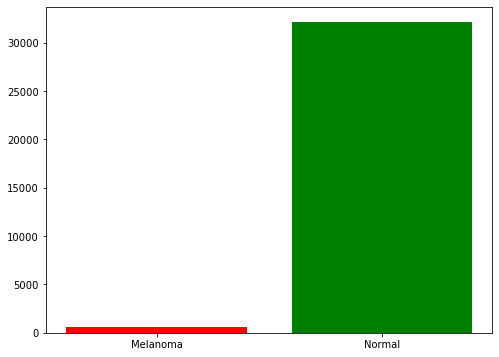

In [8]:
# lets visualize the class distribution
plt.figure(figsize = (8,6))
plt.bar(["Melanoma","Normal"],[len(train[train.target==1]), len(train[train.target==0])],color = 'rg')

**To begin with, let us first observe the benign and malignant classified images.**

In [9]:
df_benign=train[train['target']==0].sample(2000)
df_malignant=train[train['target']==1]

Benign Cases


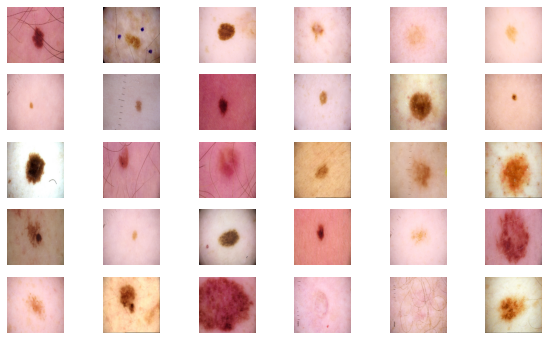

In [10]:
print('Benign Cases')
benign=[]
df_b=df_benign.head(30)
df_b=df_b.reset_index()
for i in range(30):
    img=cv2.imread(str(train_dir + df_benign['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    benign.append(img)
f, ax = plt.subplots(5,6, figsize=(10,6))
for i, img in enumerate(benign):
        ax[i//6, i%6].imshow(img)
        ax[i//6, i%6].axis('off')
        
plt.show()

Malignant Cases


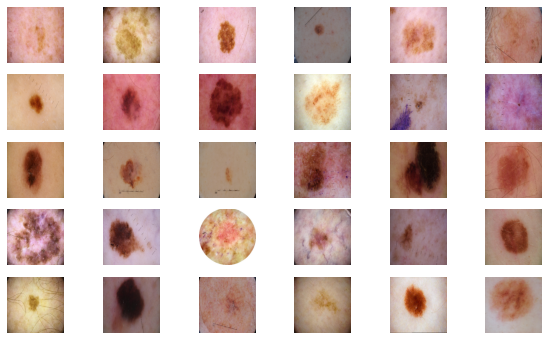

In [11]:
print('Malignant Cases')
m=[]
df_m=df_malignant.head(30)
df_m=df_m.reset_index()
for i in range(30):
    img=cv2.imread(str(train_dir + df_m['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    m.append(img)
f, ax = plt.subplots(5,6, figsize=(10,6))
for i, img in enumerate(m):
        ax[i//6, i%6].imshow(img)
        ax[i//6, i%6].axis('off')
        
plt.show()

**Percentage of benign cases VS Malignant cases**

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32701 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     32701 non-null  object 
 1   patient_id                     32701 non-null  object 
 2   sex                            32660 non-null  object 
 3   age_approx                     32657 non-null  float64
 4   anatom_site_general_challenge  32175 non-null  object 
 5   diagnosis                      32701 non-null  object 
 6   benign_malignant               32701 non-null  object 
 7   target                         32701 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.2+ MB


In [13]:
import plotly.express as px

fig = px.pie(train, train['target'],color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Naturally, as medical data is bound to have irregularities, about 98.2% data is benign.

In [14]:
train_nona=train.dropna()
#fig = px.treemap(train_nona, path=['sex', 'age_approx'], values='target', color='target')
#fig.show()

Also, the samples have recorded that amount of data recorded for males is greater than that of women.

In [15]:
entire=train.append(test)
affected_areas=pd.value_counts(entire['anatom_site_general_challenge'])
fig = go.Figure(data=[go.Pie(labels=affected_areas.index, values=affected_areas.values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value',textfont_size=15,
                  marker=dict(colors=['#11100b','#ff3560'], line=dict(color='#FFFFFF', width=2.5)))
fig.update_layout(
    title='AFFECTED AREAS')
py.iplot(fig)

**Analysing Malignant data**

In [16]:
df_malignant=df_malignant.dropna()

In [17]:
age_counts=pd.value_counts(df_malignant['age_approx'])
gender_counts=pd.value_counts(df_malignant['sex'])
anatom_site_counts=pd.value_counts(df_malignant['anatom_site_general_challenge'])

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "xy"},{"type": "domain"}, {"type": "xy"}]])

fig.add_trace(go.Bar(y=age_counts.values, x=age_counts.index),row=1, col=1)


fig.add_trace(go.Pie(values=gender_counts.values, labels=gender_counts.index,marker=dict(colors=['#100b','#f00560'], line=dict(color='#FFFFFF', width=2.5))),
              row=1, col=2)

fig.add_trace(go.Scatter(x=anatom_site_counts.index, y=anatom_site_counts.values),
              row=1, col=3)

fig.update_layout(height=700, showlegend=False)

fig.update_xaxes(title_text="Age", row=1, col=1)
fig.update_xaxes(title_text="Site", row=1, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=3)

# Update title and height
fig.update_layout(title_text="MALIGNANT DATA wrt AGE, GENDER, SITE",height=600, width=1000)

fig.show()

Some Inferences from the above plots are:
* Majority of the patients who have malignant reports are in the age range of 50-80 years.
* About 62% of the patients who tested malignant were males.
* Torso, Upper extremity and Lower extremity are the most common sites for melanoma appearance.

# Some insights about the training and testing data


**Age diversity in training data Vs Age diversity in testing data**

In [18]:
agecounts=pd.value_counts(train['age_approx'])
fig = px.bar(train, x=agecounts.index, y=agecounts.values)
fig.update_layout(title_text='Age counts of the training data')
fig.show()

In [19]:
agecounts=pd.value_counts(test['age_approx'])
fig = px.bar(test, x=agecounts.index, y=agecounts.values)
fig.update_layout(title_text='Age counts of the testing data')
fig.show()

The irregularities in age groups is not as evident. Both the training and testing data have a majority of reports from the 40-50 age group. Although the reports from the age 70 and above are comparatively less in testing data than in training data.

## Melanoma skin site appearance in training data vs in testing data

In [20]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}]])

site_train_counts=pd.value_counts(train['anatom_site_general_challenge'])

fig.add_trace(go.Pie(values=site_train_counts.values, labels=site_train_counts.index,title_text='Melanoma regions for training dataset',marker=dict(colors=['#100b','#f00560'], line=dict(color='#FFFFFF', width=2.5))),
              row=1, col=1)

site_test_counts=pd.value_counts(test['anatom_site_general_challenge'])

fig.add_trace(go.Pie(values=site_test_counts.values, labels=site_test_counts.index,title_text='Melanoma regions for testing dataset',marker=dict(colors=['#100b','#f00560'], line=dict(color='#FFFFFF', width=2.5))),
              row=1, col=2)

fig.update_layout(height=700, showlegend=False)

fig.show()

So, if we compare the training and testing data side by side, the area where melanoma signs appear are similar. The most common region is torso followed by lower extremity.

# Modelling - VGG16 (Transfer Learning)

## Data Preparation

* ### Take Sample Images for training

In [21]:
# Since this is a huge dataset, we would take a sample of it for training purpose

df_0=train[train['target']==0].sample(2000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

* ### Update Image Names

In [22]:
# update image names with the whole path
def append_ext(fn):
    return train_dir+fn+".jpg"
train["image_name"]=train["image_name"].apply(append_ext)

def append_ext(fn):
    return test_dir+fn+".jpg"
test["image_name"]=test["image_name"].apply(append_ext)

* ### Split into train and validate dataset

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train['image_name'],train['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['image_name']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['image_name']
validation['target']=y_val

* ### Resize Images
Resizing images is a critical preprocessing step in computer vision. Principally, our machine learning models train faster on smaller images. An input image that is twice as large requires our network to learn from four times as many pixels — and that time adds up.

In [24]:
# resizing the images
IMG_DIM = (224, 224)

# load images
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train.image_name]
train_imgs = np.array(train_imgs)

validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation.image_name]
validation_imgs = np.array(validation_imgs)

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (2064, 224, 224, 3) 	Validation dataset shape: (517, 224, 224, 3)


In [25]:
# define parameters for model training
batch_size = 128
num_classes = 2
epochs = 30
input_shape = (224, 224, 3)

We would leverage Transfer Learning Models for image classification, but why Transfer Learning and not Traditional ML/DL Algorithms?
Let's find out!

# Problem with conventional ML & DL Algorithms

Humans have an inherent ability to transfer knowledge across tasks. What we acquire as knowledge while learning about one task, we utilize in the same way to solve related tasks. The more related the tasks, the easier it is for us to transfer, or cross-utilize our knowledge. Some simple examples would be,
    
*     Know how to ride a motorbike ⮫ Learn how to ride a car
*     Know how to play classic piano ⮫ Learn how to play jazz piano
*     Know math and statistics ⮫ Learn machine learning

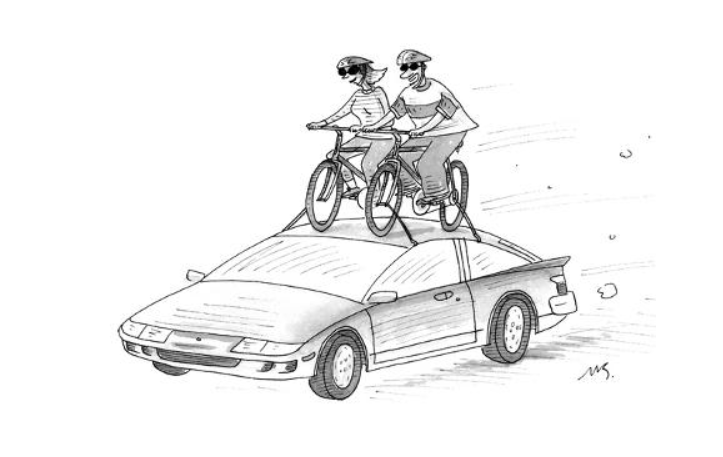

In each of the above scenarios, we don’t learn everything from scratch when we attempt to learn new aspects or topics. We transfer and leverage our knowledge from what we have learnt in the past!

Conventional machine learning and deep learning algorithms, so far, have been traditionally designed to work in isolation. 

These algorithms are trained to solve specific tasks. The models have to be rebuilt from scratch once the feature-space distribution changes. 

# What is Transfer Learning - An Introduction

In transfer learning, you can leverage knowledge (features, weights etc) from previously trained models for training newer models and even tackle problems like having less data for the newer task!

* ### Motivation for Transfer Learning
    We have already briefly discussed that humans don’t learn everything from the ground up and leverage and transfer their knowledge from previously learnt domains to newer domains and tasks. 

    Thus, the key motivation, especially considering the context of deep learning is the fact that most models which solve complex problems need a whole lot of data, and getting vast amounts of labeled data for supervised models can be really difficult, considering the time and effort it takes to label data points. 
    A simple example would be the ImageNet dataset, which has millions of images pertaining to different categories, thanks to years of hard work starting at Stanford!

    However, getting such a dataset for every domain is tough. Besides, most deep learning models are very specialized to a particular domain or even a specific task. 
    While these might be state-of-the-art models, with really high accuracy and beating all benchmarks, it would be only on very specific datasets and end up suffering a significant loss in performance when used in a new task which might still be similar to the one it was trained on. 
    This forms the motivation for transfer learning, which goes beyond specific tasks and domains, and tries to see how to leverage knowledge from pre-trained models and use it to solve new problems!
    

* ### Understanding Transfer Learning

    The first thing to remember here is that, transfer learning, is not a new concept which is very specific to deep learning. There is a stark difference between the traditional approach of building and training machine learning models, and using a methodology following transfer learning principles.

    Below picture shows the difference between traditional ML vs Transfer Learning

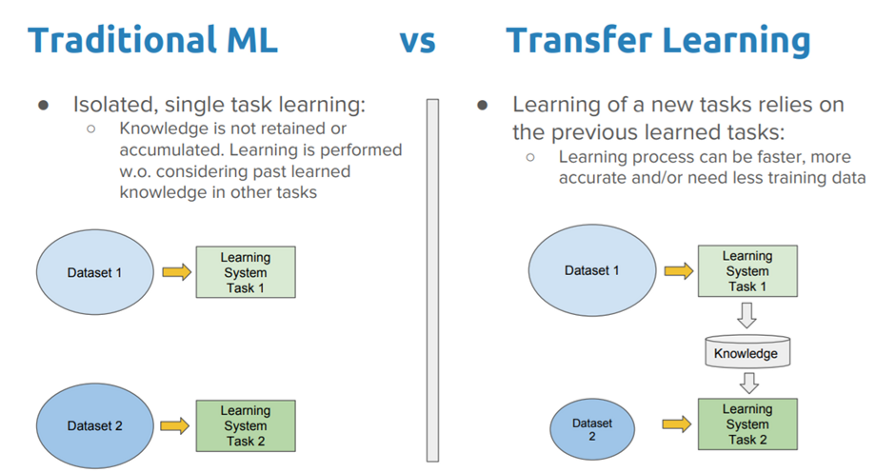

Traditional learning is isolated and occurs purely based on specific tasks, datasets and training separate isolated models on them.
No knowledge is retained which can be transferred from one model to another.  In transfer learning, you can leverage knowledge
(features, weights etc) from previously trained models for training newer models and even tackle problems like having less data for the newer task!

**The following terminology is very important with regard to training our model:**

* The batch_size indicates the total number of images passed to the model per iteration.

* The weights of the units in layers are updated after each iteration.

* The total number of iterations is always equal to the total number of training samples divided by the batch_size.

* An epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches.

We will be using VGG16 model(Transfer Learning) for image classification

### Define loss function
We are taking focal loss because the dataset is an imbalanced dataset

In [26]:
# focal loss
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

### Optimizer & No. of Iterations

In [27]:
# we will use Adam optimizer
opt = Adam(lr=1e-5)

#total number of iterations is always equal to the total number of training samples divided by the batch_size.
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 16 and 4


### Image Augmentation & Pixels Normalization

**Image Augmentation:**
The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don’t get the same images each time, and we will leverage Python generators to feed in these new images to our model during training.

The Keras framework has an excellent utility called ImageDataGenerator that can help us in doing all the preceding operations. Let’s initialize two of the data generators for our training and validation datasets.

**Pixel Nomralization:**
Neural networks process inputs using small weight values, and inputs with large integer values can disrupt 
or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value 
between 0 and 1. Parameter "rescale" used below does pixel normalization for us.

In [28]:
# Pixel Normalization and Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

# no need to create augmentation images for validation data, only rescaling the pixels
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs, y_val, batch_size=batch_size)

There are a lot of options available in ImageDataGenerator and we have just utilized a few of them. Feel free to check out the documentation to get a more detailed perspective. In our training data generator, we take in the raw images and then perform several transformations on them to generate new images. These include the following.

    Zooming the image randomly by a factor of 0.3 using the zoom_range parameter.

    Rotating the image randomly by 50 degrees using the rotation_range parameter.

    Translating the image randomly horizontally or vertically by a 0.2 factor of the image’s width 
    or height using the width_shift_range and the height_shift_range parameters.

    Applying shear-based transformations randomly using the shear_range parameter.

    Randomly flipping half of the images horizontally using the horizontal_flip parameter.

    Leveraging the fill_mode parameter to fill in new pixels for images after we apply any of the preceding operations 
    (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

Let’s see how some of these generated images might look so that you can understand them better. We will take two sample images from our training dataset to illustrate the same. The first image is an image of a cat.


Labels: [0, 0, 0, 0, 0]


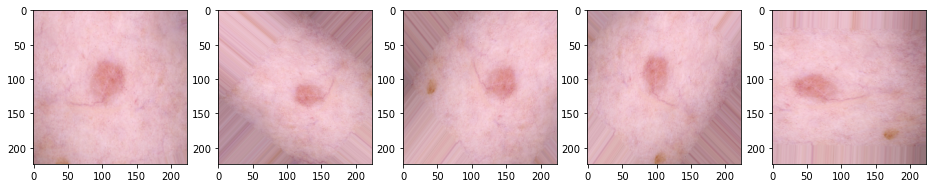

In [29]:
img_id = 100
generator_100 = train_datagen.flow(train_imgs[img_id:img_id+1], train.target[img_id:img_id+1],
                                   batch_size=1)
aug_img = [next(generator_100) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in aug_img])
l = [ax[i].imshow(aug_img[i][0][0]) for i in range(0,5)]

In [30]:
import gc
del train
gc.collect()

35

### Define VGG16 Model

In [31]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

58892288/58889256 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f15f8eb3f50>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1594ffa8d0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15f8745bd0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f159466c810>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941b4cd0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f159466cc50>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f15941cf350>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941d2490>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941cfa50>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1594163c50>,block3_conv3,False


In [32]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f15f8eb3f50>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1594ffa8d0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15f8745bd0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f159466c810>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941b4cd0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f159466cc50>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f15941cf350>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941d2490>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15941cfa50>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1594163c50>,block3_conv3,False


In [33]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [34]:
#!pip install livelossplot
#from livelossplot import PlotLossesKeras

In [35]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [36]:
#cb=[PlotLossesKeras()]
model.fit_generator(train_generator, steps_per_epoch=nb_train_steps, epochs=epochs,callbacks=[es],
                              validation_data=val_generator, validation_steps=nb_val_steps, 
                              verbose=1)


Epoch 1/30
16/16 [==============================] - 24s 1s/step - loss: 0.1320 - auc: 0.4859 - val_loss: 0.0834 - val_auc: 0.4677
Epoch 2/30
16/16 [==============================] - 25s 2s/step - loss: 0.0620 - auc: 0.5313 - val_loss: 0.0511 - val_auc: 0.6329
Epoch 3/30
16/16 [==============================] - 24s 2s/step - loss: 0.0577 - auc: 0.5431 - val_loss: 0.0551 - val_auc: 0.6676
Epoch 4/30
16/16 [==============================] - 25s 2s/step - loss: 0.0549 - auc: 0.6015 - val_loss: 0.0490 - val_auc: 0.7302
Epoch 5/30
16/16 [==============================] - 24s 2s/step - loss: 0.0527 - auc: 0.6182 - val_loss: 0.0497 - val_auc: 0.7454
Epoch 6/30
16/16 [==============================] - 25s 2s/step - loss: 0.0509 - auc: 0.6631 - val_loss: 0.0483 - val_auc: 0.7787
Epoch 7/30
16/16 [==============================] - 24s 1s/step - loss: 0.0507 - auc: 0.6801 - val_loss: 0.0467 - val_auc: 0.7940
Epoch 8/30
16/16 [==============================] - 26s 2s/step - loss: 0.0488 - auc: 0.69

In [37]:
x_test = np.load('../input/siimisic-melanoma-resized-images/x_test_224.npy')
x_test = x_test.astype('float16')
test_imgs_scaled = x_test / 255
del x_test
gc.collect()

63

In [38]:
target=[]
i = 0
for img in test_imgs_scaled:
    img1=np.reshape(img,(1,224,224,3))
    prediction=model.predict(img1)
    i = i + 1
    print("predicted image no.",i)
    target.append(prediction[0][0])

predicted image no. 1
predicted image no. 2
predicted image no. 3
predicted image no. 4
predicted image no. 5
predicted image no. 6
predicted image no. 7
predicted image no. 8
predicted image no. 9
predicted image no. 10
predicted image no. 11
predicted image no. 12
predicted image no. 13
predicted image no. 14
predicted image no. 15
predicted image no. 16
predicted image no. 17
predicted image no. 18
predicted image no. 19
predicted image no. 20
predicted image no. 21
predicted image no. 22
predicted image no. 23
predicted image no. 24
predicted image no. 25
predicted image no. 26
predicted image no. 27
predicted image no. 28
predicted image no. 29
predicted image no. 30
predicted image no. 31
predicted image no. 32
predicted image no. 33
predicted image no. 34
predicted image no. 35
predicted image no. 36
predicted image no. 37
predicted image no. 38
predicted image no. 39
predicted image no. 40
predicted image no. 41
predicted image no. 42
predicted image no. 43
predicted image no. 

In [39]:
# submission file
sub=pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sub['target']=target
#sub.to_csv('submission.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.145222
1,ISIC_0052349,0.210398
2,ISIC_0058510,0.118599
3,ISIC_0073313,0.049382
4,ISIC_0073502,0.389137


# Creating Ensemble of Models generated by training image data and by tabular data

In [40]:
#img_csv=sub.copy()
tab_csv=pd.read_csv('../input/image-and-tab-csv-files/submission_tab.csv')
#img_csv.head()

In [41]:
img_csv=pd.read_csv('../input/image-and-tab-csv-files/submission_img.csv')

In [42]:
sub=img_csv.copy()
sub['target']= (img_csv['target'] + tab_csv['target'])/2
#sub['target']= img_csv['target'] * 0.8 + tab_csv['target'] * 0.2
sub.head()

,image_name,target
0,ISIC_0052060,0.015568
1,ISIC_0052349,0.011202
2,ISIC_0058510,0.002056
3,ISIC_0073313,0.001258
4,ISIC_0073502,0.182023


In [43]:
sub.to_csv('submission.csv',index=False)